In [1]:
import os
import re

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(44)
tf.config.experimental.enable_op_determinism()

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

import keras.metrics as km


In [2]:
train = pd.read_csv('cleaned_df/stance_abortion_train_cleaned.csv')
test = pd.read_csv('cleaned_df/stance_abortion_test_cleaned.csv')
validation = pd.read_csv('cleaned_df/stance_abortion_validation_cleaned.csv')

### Preprocess Text

#### Contraction Mapping

In [3]:
# Mapping of common contractions, no apostrophes 
CONTRACTION_MAPPING = {"aint": "is not", "arent": "are not","cant": "cannot", "'cause": "because", "cos": "because", "couldve": "could have", 
                       "couldnt": "could not", "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not", 
                       "hasnt": "has not", "havent": "have not", "hed": "he would","hell": "he will", "hes": "he is", 
                       "howd": "how did", "how'd'y": "how do you", "howll": "how will", "hows": "how is",  "Id": "I would", 
                       "Idve": "I would have", "Ill": "I will", "Illve": "I will have","Im": "I am", "Ive": "I have", 
                       "id": "i would", "idve": "i would have", "ill": "i will",  "illve": "i will have", "im": "i am", 
                       "ive": "i have", "isnt": "is not", "itd": "it would", "itdve": "it would have", "itll": "it will", 
                       "itllve": "it will have","its": "it is", "lets": "let us", "maam": "madam", "maynt": "may not", 
                       "mightve": "might have","mightnt": "might not","mightntve": "might not have", "mustve": "must have", 
                       "mustnt": "must not", "mustntve": "must not have", "neednt": "need not", "needntve": "need not have",
                       "o'clock": "of the clock", "oughtnt": "ought not", "oughtntve": "ought not have", "shant": "shall not", 
                       "shant": "shall not", "shantve": "shall not have", "shed": "she would", "shedve": "she would have", 
                       "shell": "she will", "shellve": "she will have", "shes": "she is", "shouldve": "should have", 
                       "shouldnt": "should not", "shouldntve": "should not have", "sove": "so have", 
                       "thatd": "that would", "thatdve": "that would have", "thats": "that is", 
                       "thered": "there would", "theredve": "there would have", "theres": "there is", "heres": "here is",
                       "theyd": "they would", "theydve": "they would have", "theyll": "they will", "theyllve": 
                       "they will have", "theyre": "they are", "theyve": "they have",  "wasnt": "was not", 
                       "wed": "we would", "wedve": "we would have", "wellve": "we will have", 
                        "weve": "we have", "werent": "were not", "whatll": "what will", "hell": "he will",
                       "whatllve": "what will have", "whatre": "what are",  "whats": "what is", "whatve": "what have", 
                       "whens": "when is", "whenve": "when have", "whered": "where did", "wheres": "where is", 
                       "whereve": "where have", "wholl": "who will", "whollve": "who will have", "whos": "who is", 
                       "whove": "who have", "whys": "why is", "whyve": "why have", "willve": "will have", "wont": "will not", 
                       "wontve": "will not have", "wouldve": "would have", "wouldnt": "would not", "wouldntve": "would not have", 
                       "yall": "you all", "yalld": "you all would","yalldve": "you all would have",
                       "youd": "you would", "youdve": "you would have", "youll": "you will", 
                       "youllve": "you will have", "youre": "you are", "youve": "you have", "Its": 'It is', "Cant": 'Can not',
                      }

In [4]:
def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")

    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(t)
    return ' '.join(mapped_string)

In [5]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)

train_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in train['text'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in test['text'].values]
validation_vec = [clean_text(text, CONTRACTION_MAPPING) for text in validation['text'].values]

#### Tokenizing and Padding

+ Tokenizing text involves converting each sequence into an integer encoded represenation and normalizing the length of the sequences. 
+ The tweet data after preprocessing does not necessarily have the same size.
+ RNN requires to have all the inputs of same shape, there was a need to add padding to each tweet and target sequences.
+ The max length of the tweet and target was evaluated and a padding was added to each tweet and target sequence with the max tweet and target length.


In [6]:
#training constants
MAX_SEQ_LEN = train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95).astype(np.int64)
DEFAULT_BATCH_SIZE = 128

print(MAX_SEQ_LEN)

18


In [7]:
# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)
validation_vec = tokenizer.texts_to_sequences(validation_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)
validation_vec = pad_sequences(validation_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print('Max Token Index:', train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train['text'].values[73])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[73]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 2300
Max Token Index: 2300 

Sample Tweet Before Processing: rise shine its new day youre alive thank god another day precious life christian catholic teamjesus
Sample Tweet After Processing: ['rise shine it is new day you are alive thank god another day precious life christian catholic teamjesus'] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 801, 802, 5, 71, 347, 803, 132, 278, 493, 118, 186]


#### Encode Target

+ Stance is classified into None (no classification), Against, or Favour 
+ To make it suitable for a deep learning model each sentiment will be converted to a vector of length 3, where each position corresponds to a sentiment class: None = 0, Against = 1 and Favour = 2

In [8]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['label'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['label'].values)
y_test = to_categorical(y_test) 

y_validation = encoder.fit_transform(validation['label'].values)
y_validation = to_categorical(y_validation) 

#### Handling Class Imbalance
+ Reweighting classes to deal with large class imbalance found in the dataset

In [9]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(train['label'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)

cws = class_weight.compute_class_weight(class_weight = "balanced", 
                                        classes = np.unique(y_train_int),
                                        y = y_train_int)
cws = {i : cws[i] for i in range(3)}
print(cws)

Distribution of Classes: Counter({1: 319, 0: 158, 2: 109})
{0: 1.2362869198312236, 1: 0.6123301985370951, 2: 1.7920489296636086}


## Building a neural network model 

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

optimizer = RMSprop(learning_rate=0.01)
np.set_printoptions(precision=4)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    target_names = ['none', 'against', 'favour']
    _cm = confusion_matrix(y_true, y_pred)
    
    print(classification_report(y_true, y_pred, target_names=target_names))

        
    def _build_matrix(fig, ax, cm, normalize = False):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, cmap=cmap)
#         fig.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=target_names, 
               yticklabels=target_names,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
    fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
    _build_matrix(fig, ax1, cm = _cm, normalize=False)
    _build_matrix(fig, ax2, cm = _cm, normalize=True)
    fig.tight_layout()

In [11]:
from sklearn.metrics import recall_score, precision_score
scores = []

def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train_model(model, 
          X_train, y_train, X_test, y_test, X_validation, y_validation,
          class_weights,
          checkpoint_path, 
          epochs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
           
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),  
        epochs=epochs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 

    m.save_weights(checkpoint_path.format(epoch=0))

    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)
    score = f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted')

    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', score)
    
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()   
     
    return m, predictions, score #returns best performing model



### Simple LSTM

+ Embedding - Matrix of Word Vectors, where each vector store the "meaning" of the word. These can be trained on the fly or you can leverage existing pre-trained vector.
+ LSTM - Recurrent Neural Network that allows for the "building" of state over time
+ Dense(64) - Feed Forward Neural Net used to interpret the LSTM Output
+ Dense(3) - This it the output of the model, 3 nodes corresponding to each class. The softmax output will ensure that the sum of values = 1.0 for each output.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 128)           294528    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 434,563
Trainable params: 434,563
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
5/5 - 4s - loss: 1.2484 - accuracy: 0.3242 - precision: 0.3982 - recall: 0.1536 - val_loss: 1.1880 - val_accuracy: 0.3030 - val_precision: 0.3226 - val_recall: 0.1515

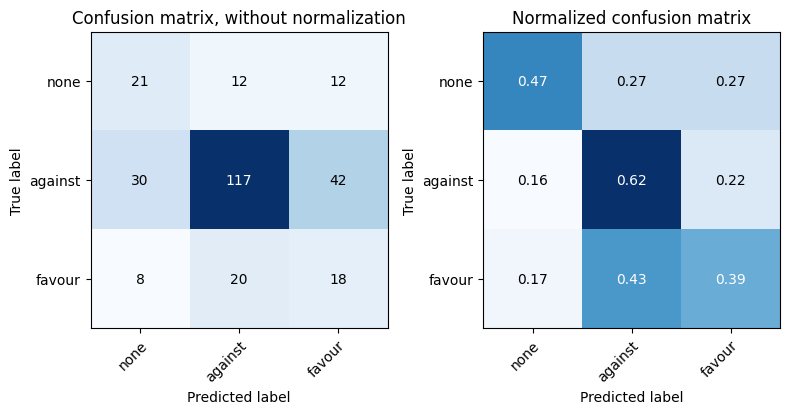

In [12]:
def model_1():
    """
    Using a Simple LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                   metrics=['accuracy', km.Precision(), km.Recall()])
    return model

m1, predictions_a, score = train_model(model_1, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           class_weights=cws,
           checkpoint_path='saved_models/abortion/model_1a.h5',
          )

scores.append(score)

### Bi-Directional LSTM
+ The Bi-directional layer "reads" text both forwards and backwards and allows the model to get information from past and future states simultaneously
+ A Dropout layer is also added to avoid overfitting. This layer drops data from the input but only during training.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18, 128)           294528    
                                                                 
 spatial_dropout1d (SpatialD  (None, 18, 128)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                

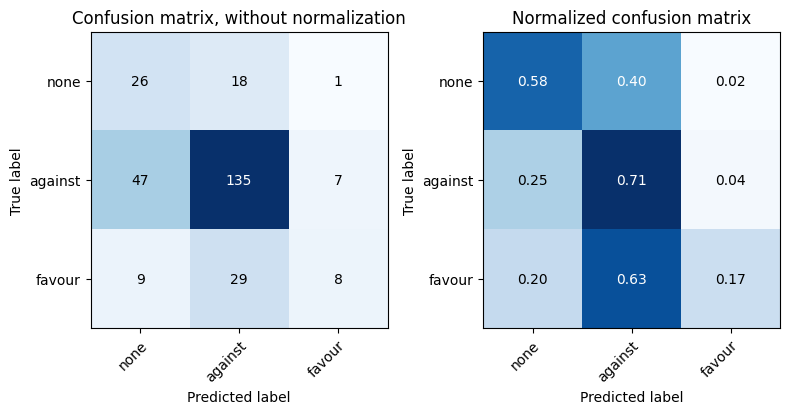

In [13]:
def model_1b():
    """
    Using a Bidiretional LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy', km.Precision(), km.Recall()])
    return model

m1b, predictions_b, score = train_model(model_1b, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/abortion/model_1b.h5',
           class_weights=cws,
           print_summary = True
          )

scores.append(score)

### Including convolutions
+ Adding Convolutions stacked on top of each state vector is a technique that assumes that related information is locally "grouped" together (a kernel)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 18, 128)           294528    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 18, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 256)          263168    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            65600     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                      

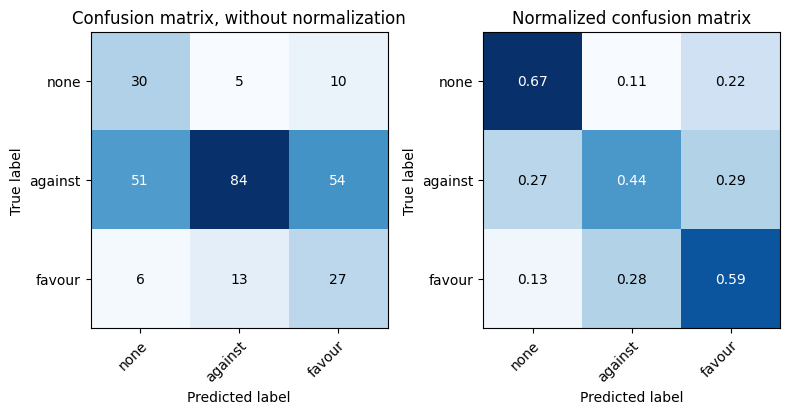

In [14]:
def model_1c():
    """
    Adding dropout to reduce overfitting using a bidiretional LSTM
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy', km.Precision(), km.Recall()])
#     print(model.summary())
    return model


m1c, predictions_c, score = train_model(model_1c, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/abortion/model_1c.h5',
           class_weights=cws,
           print_summary = True
          )

scores.append(score)

#### Experimentation
+ This version of LSTM experiments with a combination of different layers previously used

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 18, 128)           294528    
                                                                 
 bidirectional_2 (Bidirectio  (None, 18, 512)          788480    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 18, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 18, 128)           328192    
                                                                 
 dropout_2 (Dropout)         (None, 18, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                      

c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

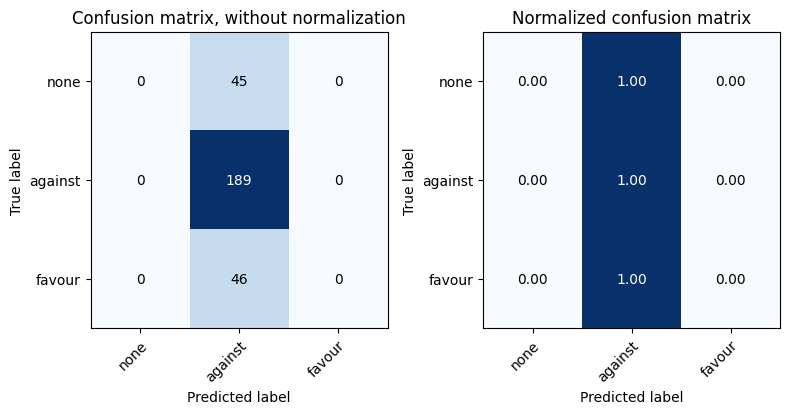

In [15]:
def model_1d():
    """
    Experimenting with other specifications
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
    model.add(Dropout(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss ='categorical_crossentropy', 
                  optimizer = optimizer, 
                  metrics = ['accuracy', km.Precision(), km.Recall()])
    return model


m1d, predictions_d, score = train_model(model_1d, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/abortion/model_1d.h5',
           class_weights=cws,
           print_summary = True
          )

scores.append(score)

### Using transfer learning

+ With a small sample size, the previous models would not be able to sufficiently learn to disiguish the meaning or intent of the limited number of tokens
+ Transfer Learning is a technique wherein existing model weights are repurposed for a new task 
+ The next models use two pre-trained word embedding models developed using the Global Vectors for Word Representation (GloVe) algorithm, specifically trained on a large corpus of tweets from Twitter: `glove-twitter-25` and `glove-twitter-100`

In [16]:
import gensim.downloader as api

tw25_model = api.load("glove-twitter-25")
tw100_model = api.load("glove-twitter-100")


In [17]:
word_index = tokenizer.word_index

def get_embeddings_matrix(embedding_model, word_index):

    embedding_dim = embedding_model.vector_size

    # Create the embedding matrix for vocabulary
    embedding_matrix = np.zeros(((len(tokenizer.word_counts) + 1), embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model.key_to_index:
            embedding_matrix[i] = embedding_model.get_vector(word)
    
    return embedding_matrix
        

In [18]:
def model_2(embed_matrix):
    """
    Extends model_1 with a glove embedding
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], 
                        output_dim = embed_matrix.shape[1], 
                        input_length = MAX_SEQ_LEN,  
                        weights=[embed_matrix], 
                        trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                   metrics=['accuracy', km.Precision(), km.Recall()])
    return model


#### Glove-twitter-25

Epoch 1/25
5/5 - 13s - loss: 7.2550 - accuracy: 0.3242 - precision_4: 0.3253 - recall_4: 0.2543 - val_loss: 5.4211 - val_accuracy: 0.1818 - val_precision_4: 0.1818 - val_recall_4: 0.1818 - 13s/epoch - 3s/step
Epoch 2/25
5/5 - 0s - loss: 2.8590 - accuracy: 0.3993 - precision_4: 0.3878 - recall_4: 0.3481 - val_loss: 1.1461 - val_accuracy: 0.1970 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - 440ms/epoch - 88ms/step
Epoch 3/25
5/5 - 0s - loss: 1.0787 - accuracy: 0.3174 - precision_4: 0.4583 - recall_4: 0.0188 - val_loss: 1.1111 - val_accuracy: 0.3333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - 491ms/epoch - 98ms/step
Epoch 4/25
5/5 - 0s - loss: 1.0708 - accuracy: 0.3788 - precision_4: 0.6279 - recall_4: 0.0461 - val_loss: 1.0119 - val_accuracy: 0.5455 - val_precision_4: 0.5000 - val_recall_4: 0.0152 - 477ms/epoch - 95ms/step
Epoch 5/25
5/5 - 0s - loss: 1.0295 - accuracy: 0.4795 - precision_4: 0.6116 - recall_4: 0.1263 - val_loss: 0.9731 - val_accuracy: 0.5455 - 

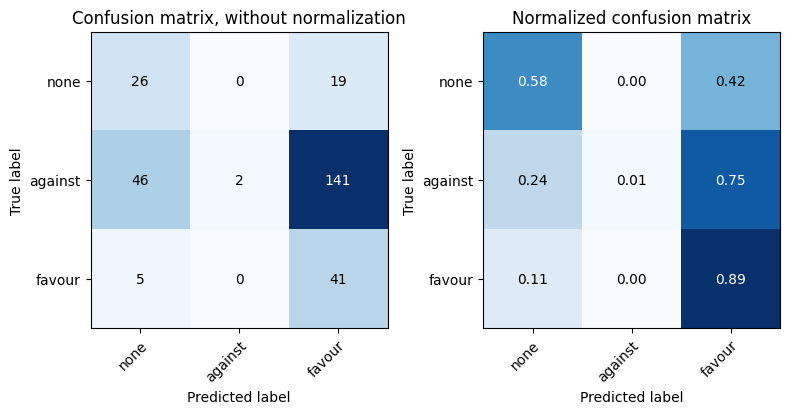

In [19]:
tw25_embed_matrix = get_embeddings_matrix(tw25_model, word_index)

m2_tw25, predictions_tw25, score = train_model(lambda : model_2(tw25_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/abortion/tw25_model.h5',
           class_weights=cws,
           fit_verbose = 2,
           print_summary = False
           )

scores.append(score)

#### Glove-twitter-100

Epoch 1/25
5/5 - 14s - loss: 6.5178 - accuracy: 0.2645 - precision_5: 0.2817 - recall_5: 0.2201 - val_loss: 1.4916 - val_accuracy: 0.5455 - val_precision_5: 0.5455 - val_recall_5: 0.5455 - 14s/epoch - 3s/step
Epoch 2/25
5/5 - 1s - loss: 1.4787 - accuracy: 0.4300 - precision_5: 0.3978 - recall_5: 0.1826 - val_loss: 1.0813 - val_accuracy: 0.5000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - 808ms/epoch - 162ms/step
Epoch 3/25
5/5 - 1s - loss: 1.0662 - accuracy: 0.4915 - precision_5: 1.0000 - recall_5: 0.0051 - val_loss: 1.1369 - val_accuracy: 0.3485 - val_precision_5: 0.6000 - val_recall_5: 0.0455 - 788ms/epoch - 158ms/step
Epoch 4/25
5/5 - 1s - loss: 1.0458 - accuracy: 0.4710 - precision_5: 0.6308 - recall_5: 0.0700 - val_loss: 0.9410 - val_accuracy: 0.5758 - val_precision_5: 0.9444 - val_recall_5: 0.2576 - 807ms/epoch - 161ms/step
Epoch 5/25
5/5 - 1s - loss: 0.9866 - accuracy: 0.5358 - precision_5: 0.7816 - recall_5: 0.2321 - val_loss: 0.8622 - val_accuracy: 0.5606 - val_p

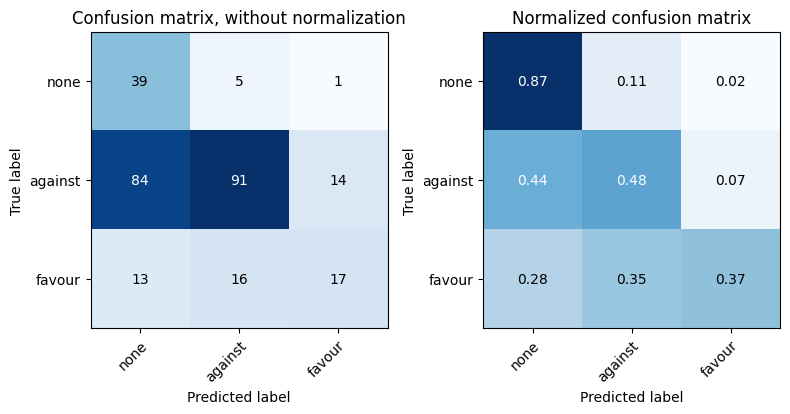

In [20]:
tw100_embed_matrix = get_embeddings_matrix(tw100_model, word_index)

m2_tw100, predictions_tw100, score = train_model(lambda : model_2(tw100_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/abortion/tw100_model.h5',
           class_weights=cws,
           fit_verbose = 2,
           print_summary = False
           )

scores.append(score)

#### Stacked

+ See if using both embeddings improve results

Epoch 1/25
5/5 - 13s - loss: 6.2768 - accuracy: 0.3106 - precision_6: 0.3043 - recall_6: 0.2389 - val_loss: 1.7594 - val_accuracy: 0.4848 - val_precision_6: 0.4769 - val_recall_6: 0.4697 - 13s/epoch - 3s/step
Epoch 2/25
5/5 - 1s - loss: 1.9276 - accuracy: 0.3191 - precision_6: 0.3214 - recall_6: 0.2901 - val_loss: 1.1566 - val_accuracy: 0.3030 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - 704ms/epoch - 141ms/step
Epoch 3/25
5/5 - 1s - loss: 1.0796 - accuracy: 0.3549 - precision_6: 0.4412 - recall_6: 0.0256 - val_loss: 1.0638 - val_accuracy: 0.3333 - val_precision_6: 0.6667 - val_recall_6: 0.0606 - 696ms/epoch - 139ms/step
Epoch 4/25
5/5 - 1s - loss: 1.0961 - accuracy: 0.3703 - precision_6: 0.4949 - recall_6: 0.1655 - val_loss: 0.9709 - val_accuracy: 0.5909 - val_precision_6: 0.7500 - val_recall_6: 0.1818 - 713ms/epoch - 143ms/step
Epoch 5/25
5/5 - 1s - loss: 1.0102 - accuracy: 0.4881 - precision_6: 0.5590 - recall_6: 0.2184 - val_loss: 0.8976 - val_accuracy: 0.5606 - val_p

c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

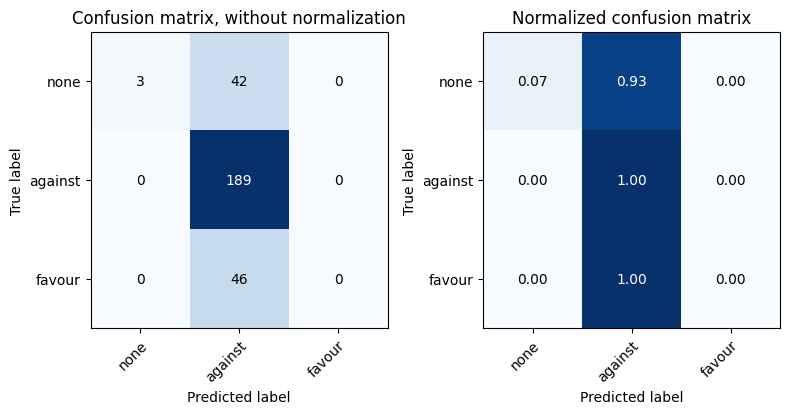

In [21]:
m2_tw_stacked, predictions_stack, score = train_model(lambda : model_2(np.hstack((tw25_embed_matrix, tw100_embed_matrix))), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/abortion/stack_embed_model.h5',
           class_weights=cws,
           fit_verbose = 2,
           print_summary = False
           )

scores.append(score)

In [22]:
from prettytable import PrettyTable

# Example list of data

models = ['Simple LSTM', 
          'BiDirectional', 
          'Convolutional', 
          'Experimentation', 
          'Twitter-25', 
          'Twitter-100', 
          'Stacked']

# Create a new table with two columns
table = PrettyTable(['Models', 'F1-Score'])

# Add rows to the table with 'fruit: X' format
for i in range(len(scores)):
    table.add_row([models[i], round(scores[i]*100,2)])

# Print the table
print(table)


+-----------------+----------+
|      Models     | F1-Score |
+-----------------+----------+
|   Simple LSTM   |  58.23   |
|  BiDirectional  |  59.94   |
|  Convolutional  |  52.75   |
| Experimentation |   54.4   |
|    Twitter-25   |  13.72   |
|   Twitter-100   |   54.9   |
|     Stacked     |  56.76   |
+-----------------+----------+


### Fine Tuning 

From the table above, we see that the best performing model is the Simple LSTM. Thus, we extend this model by fine-tuning its parameters. Due to the small sample of our data, we opt not to use freezing in optimizing the model.

In [23]:
from kerastuner.tuners import RandomSearch
import kerastuner as kt

C:\Users\herre\AppData\Local\Temp\ipykernel_448\949353759.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [24]:
def build_model(hp):
    '''
    Args:
    hp - Keras tuner object
    '''
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32)))
#     for i in range(hp.Int('n_layers', 1, 4)):
#         model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
#     model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(64, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                   metrics=['accuracy', km.Precision(), km.Recall()])
    return model

In [25]:
tuner= RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=2,
        executions_per_trial=1,
        seed=1234, 
        overwrite=False,
        directory='tuning_results4'
        )

INFO:tensorflow:Reloading Tuner from tuning_results4\untitled_project\tuner0.json


In [26]:
tuner.search(
        x=train_text_vec,
        y=y_train,
        epochs=20,
        batch_size=128,
        validation_data=(validation_vec,y_validation)
)

INFO:tensorflow:Oracle triggered exit


In [27]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [28]:
def train_tuned_model(model, 
          X_train, y_train, X_test, y_test, X_validation, y_validation,
          class_weights,
          checkpoint_path, 
          epochs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
           
          fit_verbose=2,
          print_summary = True
         ):
    m = model
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),  
        epochs=epochs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 

    m.save_weights(checkpoint_path.format(epoch=0))

    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)

    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()   
     
    return m, predictions #returns best performing model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 18, 128)           294528    
                                                                 
 lstm_9 (LSTM)               (None, 288)               480384    
                                                                 
 dense_14 (Dense)            (None, 64)                18496     
                                                                 
 dense_15 (Dense)            (None, 3)                 195       
                                                                 
Total params: 793,603
Trainable params: 793,603
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
5/5 - 6s - loss: 1.8355 - accuracy: 0.2611 - precision_7: 0.2364 - recall_7: 0.1706 - val_loss: 2.0845 - val_accuracy: 0.2727 - val_precision_7: 0.2727 - val_recall

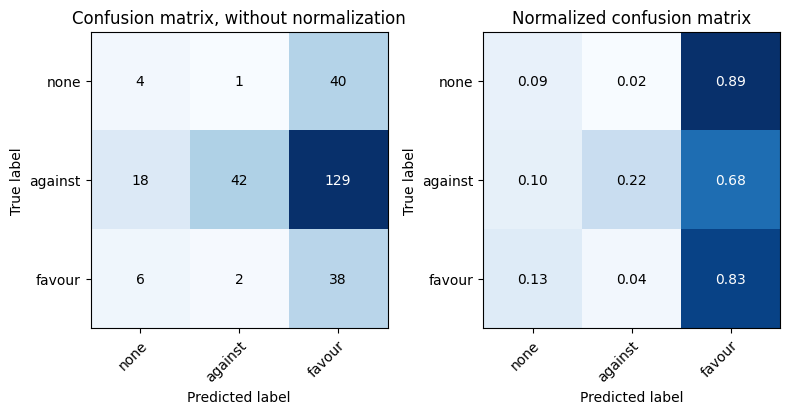

In [29]:
hp_model, predictions_hp = train_tuned_model(model, 
                        train_text_vec,
                        y_train,
                        test_text_vec,
                        y_test,
                        validation_vec,
                        y_validation,
                        class_weights=cws,
                        checkpoint_path='saved_models/abortion/tunedmodel.h5'
                        )

#### Predictions

In an RNN, the output of each time step is a vector of scores, and the softmax function can be applied to these scores to transform them into probabilities. The softmax function ensures that the output probabilities sum up to 1, which makes it easy to interpret the output as a probability distribution over the possible classes. Thus, predictions for each text is a numpy array containing the probabilities for each class.

In [ ]:
print(predictions_hp[1])
print(predictions_hp[1].sum())